# Import dependencies

### Basic utilities

In [1]:
import pathlib
import json
import csv
from pprint import pprint
import re
import unicodedata

### Data structures

In [2]:
import numpy as np
import pandas as pd

### Plotting and visualization

In [3]:
from IPython.display import display, display_html, HTML
import IPython.display as dsp

import matplotlib.pyplot as plt

import seaborn as sns

### Import statistical packages

In [4]:
# statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats import anova
from statsmodels.graphics.factorplots import interaction_plot

# scipy
from scipy import stats

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Set miscellaneous options

In [57]:
sns.set_style("whitegrid")
%matplotlib
%pylab inline

# Set the maximum number of columns for pandas to display
pd.set_option("display.max_columns",35)
pd.set_option("display.max_rows",150)
pd.options.mode.chained_assignment = None

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


---

# Utility functions

### Define function to print pretty string output in HTML format

In [6]:
def mdprint(*objects, tag=None):
    raw_string = ' '.join([str(__) for __ in objects])
    
    if tag == 'h1':
        raw_string = '<h1>{}</h1>'.format(raw_string)
    elif tag == 'h2':
        raw_string = '<h2>{}</h2>'.format(raw_string)
    elif tag == 'h3':
        raw_string = '<h3>{}</h3>'.format(raw_string)
    elif tag == 'b':
        raw_string = '<b>{}</b>'.format(raw_string)
    
    display(HTML(raw_string))

verbose_printing = False
def vprint(*args, **kwargs):
    if verbose_printing:
        mdprint(*args, **kwargs)

---

# Data file input

### Load raw data files: `get_raw_data_files()`

- Define function to load the raw data files from the `/data/mazeexperiment/participant_data/` directory
- If the experiment script was started with a certain participant number on more than one occasion, subsequent occasions have a sequence number appended to the end. This function skips any files which are less than 1000 bytes, i.e. files which resulted from a false start of the experiment script

In [7]:
def get_raw_data_files(raw_data_folder):
    raw_data_files = raw_data_folder.glob('*.csv')
    
    chosen_files = list()
    for f in raw_data_files:
        # Check to see that file is larger than 1KB
        if f.stat().st_size > 1000:
            chosen_files.append(f)
            
    return chosen_files

### Reformat data files: `reformat_raw_data_files(raw_data_files)`

- Unescaped double quotes within the all_runtime column causes the data files to be misparsed.
- This function fixes that error to make these files parseable

In [8]:
def reformat_raw_data_files(raw_data_files, reformatted_data_folder):
    reformatted_files = list()
    
    for data_file in raw_data_files:
        # Fix name of file if it contains a sequence number at the end
        fixed_name = './{}/{}'.format(str(reformatted_data_folder), data_file.name)
        m = re.search(
            '(?P<directory>\./data/mazeexperiment/participant_data-reformatted/)' +
            '(?P<basename>RPACR_\d{3}_\d{4}-\d{2}-\d{2})' +
            '(?P<subscript>_\d+)?' +
            '(?P<extension>\.\w+)', fixed_name)
        m = m.groupdict()
        fixed_name = '{}{}{}'.format(m['directory'], m['basename'], m['extension'])
        fixed_file = pathlib.Path(fixed_name)
        
        # Open the raw input file and the output file for the reformatted data
        with data_file.open('r', encoding='utf-8') as in_file, fixed_file.open('w', encoding='utf-8') as out_file:
            # Loop through each line, fix the unescaped double quote, and write the line to a new file
            count = 0
            for line in in_file:
                if count == 0:
                    out_file.writelines(line)
                    continue

                fixed_line = line.replace('systemPlatform\': "windowsversion', 'systemPlatform\': ""windowsversion')
                fixed_line = fixed_line.replace('\')", \'experi', '\')"", \'experi')
                out_file.writelines(fixed_line)
                
        reformatted_files.append(fixed_file)
        
    return reformatted_files

### Parse files: `parse_raw_data_files(raw_data_files)`

The data files contain a serialized data structure that the `csv` module misinterprets as many columns. This function will combine those columns back into a list and write the result to new output files.

In [9]:
def parse_raw_data_files(raw_data_files, parsed_data_folder):
    
    parsed_files = list()
    
    for data_file in raw_data_files:
        
        # Open the data file
        with data_file.open('r', encoding='utf-8') as f:
            csvreader = csv.reader(f, delimiter=',', quotechar='"')
            data = []

            # Append the first (header) line to the list of lines
            data.append(next(csvreader)[:-1])
            
            # Correct a series of columns that the csv package parses as many individual columns
            # rather than as items within a serialized data structure
            for line in csvreader:
                data.append(line[:41] + [', '.join(line[41:83])] + line[83:-1])
                
        # Specify location of processed data file
        parsed_data_file = '{}/{}'.format(parsed_data_folder_name, data_file.name)
        parsed_data_file = pathlib.Path(parsed_data_file)
        
        # Write out processed version of data file
        with parsed_data_file.open('w', encoding='utf-8') as f:
            csvwriter = csv.writer(f, delimiter=',', quotechar='"')
            csvwriter.writerows(data)
            
        parsed_files.append(parsed_data_file)
        
    return parsed_files

### Load and process data files for analysis

- Check to see if folder containing reformatted and parsed data folders already exists, then load files
- Otherwise, reformat and parse the loaded raw data files

In [10]:
# Specify raw data folder
raw_data_folder_name = './data/mazeexperiment/participant_data/'
raw_data_folder = pathlib.Path(raw_data_folder_name)

# Create folder to hold reformatted data
reformatted_data_folder_name = './data/mazeexperiment/participant_data-reformatted/'
reformatted_data_folder = pathlib.Path(reformatted_data_folder_name)
reformatted_data_folder.mkdir(exist_ok=True)

# Create processed data folder
parsed_data_folder_name = './data/mazeexperiment/participant_data-processed/'
parsed_data_folder = pathlib.Path(parsed_data_folder_name)
parsed_data_folder.mkdir(exist_ok=True)

# Load raw data files from disk
raw_data_files = get_raw_data_files(raw_data_folder)
mdprint('Found {} raw data files'.format(len(raw_data_files)))

# Check to see if parsed data files already exist
parsed_data_files = list(parsed_data_folder.glob('*.csv'))

# If the number of files in the parsed data directory is equal to the number
# of raw data files, skip the reformatting and parsing steps
if len(parsed_data_files) == len(raw_data_files):
    mdprint('Raw data files have already been processed.', tag='b')
    mdprint('Skipping reformatting and parsing steps...')
    data_files = list(parsed_data_files)
else:
    mdprint('Now formatting and parsing raw data files for analysis...')
    
    raw_data_files = reformat_raw_data_files(raw_data_files, reformatted_data_folder)
    mdprint('Reformatted {} raw data files'.format(len(raw_data_files)))
    
    data_files = parse_raw_data_files(raw_data_files, parsed_data_folder)

mdprint('Loaded {} data files for analysis.'.format(len(data_files)))

---

# Prepare data structures for analysis

### Aggregate all participant IDs from the data file names

In [11]:
# Aggregate all participant ID numbers
participant_ids = []

# The index of where the participant ID number starts in the file name
pid_start = data_files[0].name.index('_') + 1
for data_file in data_files:
    # Extract the ID substring for the file name and convert it to an int
    pid = np.int16(data_file.name[pid_start:pid_start+3])
    participant_ids.append(pid)

### Create empty `participants` DataFrame

In [12]:
columns = [
    'data',
    'session_time',
    'version',
    'platform',
    'hostname',
    'psychopy_version',
    'window_size',
    'window_type'
]

participants = pd.DataFrame(
    index=pd.Index(participant_ids, name='participant'),
    columns=columns
)

### Load participant data into DataFrame

#### Load data from CSV file, excluding irrelevent columns

In [13]:
def load_csv_data(data):
    
    trials_df = pd.DataFrame.from_records(
        data[1:],
        columns=data[0],
        exclude=[
            'sentence', 'practice_block.thisRepN',
            'practice_block.thisTrialN', 'practice_block.thisN',
            'practice_block.thisIndex', 'proc_count',
            'exp_name', 'all_runtime',
            'frame_rate', 'pretrial_fixation'
        ]
    )

    
    # Exclude rows without a sentence block index, i.e. practice trials
    trials_df = trials_df.loc[trials_df['sentence_block.thisIndex'] != '']
    trials_df = trials_df.rename(columns={
        'sentence_trial.thisIndex': 'sentence_index',
        'sentence_block.thisN': 'sentence_order'
    })
    
    # Rename columns that don't have a valid Pythonic name
    renamed_cols = dict()
    for col in trials_df.axes[1]:
        if '.' in col:
            renamed_cols[col] = col.replace('.', '_')
            
    trials_df = trials_df.rename(columns=renamed_cols)
    
    # Convert numeric columns from string to int
    numeric_cols = [
        'target_pos', 'resp', 'resp_acc', 'sentence_index', 'sentence_order', 'critical_index',
        'condition', 'block_acc', 'sentence_number', 'resp_RT', 'block_RT'
    ]
    trials_df[numeric_cols] = trials_df[numeric_cols].apply(pd.to_numeric).astype(np.int)
    
    return trials_df

#### Create a dataframe containing the individual item pairs in each sentence

In [14]:
def process_sentence_dataframe(trials_df):
    
    # Don't include the rows that contain block accuracy
    # Index DF by sentence number and pair index (2D)
    sentences_df = trials_df\
        .loc[np.isnan(trials_df['block_acc'])]\
        .set_index(['sentence_number', 'sentence_index'])\
        .filter([
            'pair_distractor', 'pair_correct',
            'target_pos', 'target_pos_verbose',
            'resp', 'resp_verbose',
            'resp_RT', 'resp_acc',
            'prev_pos', 'prev_resp'
        ])
    
    numeric_cols = ['target_pos', 'resp', 'resp_acc']
    sentences_df[numeric_cols] = sentences_df[numeric_cols].apply(pd.to_numeric).astype(np.int)
    
    return sentences_df

In [15]:
def adjust_critical_index(df):
    
    # Get all of the sentence numbers in the data files
    sentence_numbers = sorted(pd.unique(df['sentence_number']))
    
    # Create dataframe to hold adjusted critical indices
    adjusted_indices = pd.DataFrame(
        index=pd.Index(sentence_numbers, dtype=np.int),
        columns=['sentence_number', 'critical_index'],
        dtype=np.int
    )
    
    for sentence_number in sentence_numbers:
        for i in range(-2, 3):
            
            uniques = df.loc[
                (np.isnan(df['block_acc'])) &
                (df['sentence_number'] == sentence_number) &
                (df['sentence_index'] == df['critical_index'] + i)
            ][['pair_distractor', 'condition', 'participant', 'critical_index']]
            
            unique_distractors = pd.unique(uniques['pair_distractor'])
            unique_conditions = pd.unique(uniques['condition'])

            if len(unique_conditions) > 0 and len(unique_distractors) > 1:
                adjusted_indices.loc[sentence_number][['sentence_number', 'critical_index']] =\
                    [sentence_number, uniques.iloc[0]['critical_index'] + i]

    return adjusted_indices
                
df = None
for data_file in data_files[:50:2]:
    with data_file.open('r') as f:
        data = list(csv.reader(f, delimiter=','))
        
        if df is None:
            df = load_csv_data(data)
        else:
            df = df.append(load_csv_data(data))

adjusted_critical_indices = adjust_critical_index(df)

/Users/nick/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: the raise_on_error=False keyword is deprecated, use errors='ignore' instead


#### Create a dataframe containing block-level information for each sentence

In [16]:
def process_block_dataframe(trials_df):
    
    # Include only rows that contain block accuracy
    # Index DF by sentence number

    block_df = trials_df\
        .loc[np.isfinite(trials_df['block_acc'])]\
        .set_index(['sentence_number'])\
        .filter([
            'sentence_order', 'full_sentence', 'critical_index',
            'critical_target', 'condition',
            'critical_distractor', 'block_acc',
            'block_RT'
        ])
    
    numeric_cols = ['sentence_order', 'critical_index', 'condition', 'block_acc', 'block_RT']
    block_df[numeric_cols] = block_df[numeric_cols].apply(pd.to_numeric).astype(np.int)
    for i in range(1, len(block_df)+1):
        block_df.loc[i, 'critical_index'] = adjusted_critical_indices.loc[i]['critical_index']
    
    return block_df

#### Add condition labels to block-level information for each sentence

In [17]:
def process_condition_labels(block_df):
    
    # Define condition names and condition characteristics
    distractor_conditions = {1: 'both_sim', 2: 'orth_sim', 3: 'phon_sim', 4: 'both_dif'}
    phono_sim_condition = {1: True, 2: False, 3: True, 4: False}
    ortho_sim_condition = {1: True, 2: True, 3: False, 4: False}
    
    block_df['condition_label'] = block_df.apply(lambda row: distractor_conditions[row['condition']], axis=1)
    block_df['ortho_similarity'] = block_df.apply(lambda row: int(ortho_sim_condition[row['condition']]), axis=1)
    block_df['phono_similarity'] = block_df.apply(lambda row: int(phono_sim_condition[row['condition']]), axis=1)
    
    return block_df

#### Add stimuli characteristics to block-level information

In [18]:
def process_stim_characteristics(block_df, sentences_df):
    
    ####################################################################################
    # Load SUBTLEX character file
    ####################################################################################
    
    subtlex_chr_file = pathlib.Path('/Users/nick/github/orthophonology/data/subtlex-ch/SUBTLEX-CH-CHR.csv')
    
    with subtlex_chr_file.open('r') as f:
        subtlex_total_chr = next(f).split(': ')[1].replace(',', '').strip()
        subtlex_total_chr_contexts = next(f).split(': ')[1].replace(',', '').strip()
        
        subtlex_chr = pd.read_csv(f, sep='\t')
        
    subtlex_chr.columns = [
        'character', 'count', 'per_million', 'log_count',
        'context_count', 'context_percent', 'log_context_count'
    ]
    
    ####################################################################################
    # Load SUBTLEX word file
    ####################################################################################
    
    subtlex_word_file = pathlib.Path('/Users/nick/github/orthophonology/data/subtlex-ch/SUBTLEX-CH-WF.csv')
    
    with subtlex_word_file.open('r') as f:
        subtlex_total_word = next(f).split(': ')[1].replace(',', '').strip()
        subtlex_total_word_contexts = next(f).split(': ')[1].replace(',', '').strip()
        
        subtlex_word = pd.read_csv(f, sep='\t')
        
    subtlex_word.columns = [
        'word', 'count', 'per_million', 'log_count',
        'context_count', 'context_percent', 'log_context_count'
    ]

    ####################################################################################
    # Add frequency data to blocks
    ####################################################################################
    
    for ix, block in block_df.iterrows():
        
        ################################################################################
        # Check if the critical word was reached
        ################################################################################
        sentence = sentences_df.loc[ix]
        if block['critical_index'] in sentence.index:
            critical_pair = sentence.loc[block['critical_index']]
            block_df.loc[ix, 'critical_reached'] = 1
            
        else:
            block_df.loc[ix, 'critical_reached'] = 0
            continue
            
        
        ################################################################################
        # Process the target and distractor words
        ################################################################################
        if unicodedata.category(critical_pair['pair_correct'][-1]) == 'P':
            block_df.loc[ix, 'critical_target_word'] = critical_pair['pair_correct'][:-1]
        else:
            block_df.loc[ix, 'critical_target_word'] = critical_pair['pair_correct']
        block_df.loc[ix, 'target_length'] = len(block_df.loc[ix, 'critical_target_word'])
        
        block_df.loc[ix, 'critical_distractor_word'] = block_df.loc[ix, 'critical_distractor']
        
        # Isolate distractor character
        dist_word = block_df.loc[ix]['critical_distractor_word']
        targ_word = block_df.loc[ix]['critical_target_word']
        for charx in range(len(targ_word)):
            if dist_word[charx] != targ_word[charx]:
                block_df.loc[ix, 'critical_distractor'] = dist_word[charx]
                break
        else:
            raise ValueError('Could not isolate distractor character')
        
        
        ################################################################################
        # Get the frequencies
        ################################################################################
        # Get frequency of target character
        if len(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_target']]):
            block_df.loc[ix, 'critical_target_freq']\
                = np.float(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_target']]['log_count'])
        else:
            block_df.loc[ix, 'critical_target_freq'] = 0
        
        # Get frequency of distractor character
        if len(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_distractor']]):
            block_df.loc[ix, 'critical_distractor_freq']\
              = np.float(subtlex_chr.loc[subtlex_chr['character'] == block_df.loc[ix, 'critical_distractor']]['log_count'])
        else:
            block_df.loc[ix, 'critical_distractor_freq'] = 0
            
        
        # Get frequency of target word
        if len(subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_target_word']]):
            block_df.loc[ix, 'critical_target_word_freq'] = np.float(
                subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_target_word']]['log_count']
            )
        
        else:
            block_df.loc[ix, 'critical_target_word_freq'] = 0
            
        
        # Get frequency of distractor word
        if len(subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_distractor_word']]):    
            block_df.loc[ix, 'critical_distractor_word_freq'] = np.float(
                subtlex_word.loc[subtlex_word['word']==block_df.loc[ix,'critical_distractor_word']]['log_count']
            )
        
        else:
            block_df.loc[ix, 'critical_distractor_word_freq'] = 0
        
    # Readjust column ordering
    cols = [
        'sentence_order', 'full_sentence', 'critical_reached',
        'critical_index', 'critical_target', 'critical_distractor',
        'critical_target_word', 'critical_distractor_word', 'target_length',
        'condition', 'condition_label', 'ortho_similarity', 'phono_similarity',
        'critical_target_freq', 'critical_distractor_freq',
        'critical_target_word_freq', 'critical_distractor_word_freq',
        'block_acc', 'block_RT'
    ]
    block_df = block_df[cols]
    
    return block_df
    
    

#### Process the data files

In [19]:
count = 0
for data_file in data_files:
    count += 1

    with data_file.open('r') as f:
        csvreader = csv.reader(f, delimiter=',')
        data = list(csvreader)
    
    trials_df    = load_csv_data(data)
    
    sentences_df = process_sentence_dataframe(trials_df)
    
    block_df     = process_block_dataframe(trials_df)
    block_df     = process_condition_labels(block_df)
    block_df     = process_stim_characteristics(block_df, sentences_df)
    
    combined_df = pd.DataFrame(
        index=pd.Index(np.arange(1, len(block_df)+1), name='sentence_number'),
        columns=['block', 'sentence']
    )
    
    for row in combined_df.iterrows():
        row[1]['block'] = block_df.loc[row[0]]
        row[1]['sentence'] = sentences_df.loc[row[0]]
        
    ####################################################################################
    # Add all data to participants dataframe
    ####################################################################################
    
    # Get view of participant's row from participant dataframe
    participant_row = participants.loc[np.int(trials_df.iloc[0]['participant'])]

    # Add data to row
    participant_row['data'] = combined_df
    
    # Set participant-level information within row
    participant_row['session_time'] = '{} {}'.format(trials_df.iloc[0]['date'], trials_df.iloc[0]['session_start'])
    
    included_cols = ['version', 'platform', 'hostname', 'psychopy_version', 'window_size', 'window_type']
    participant_row[included_cols] = trials_df.iloc[0][included_cols]
    
    dsp.clear_output(wait=True)
    mdprint('Number of rows processed: {: >2}'.format(count))
    
dsp.clear_output(wait=True)
mdprint('Columns in participants:', tag='b')
mdprint(',&nbsp;&nbsp;&nbsp;'.join(list(participants.axes[1])))

### Create flat dataframe with all participant data

In [20]:
# The columns that identify participant, sentence number, and pair in the sentence
index_columns = ['participant', 'sentence_number', 'sentence_index']

# The columns that carry block-level data
block_cols = list(participants.iloc[0]['data'].iloc[0]['block'].axes[0])
block_cols.remove('full_sentence')

# The columns that carry pair-level data
sentence_cols = list(participants.iloc[0]['data'].iloc[1]['sentence'].axes[1])

# Merged list of all the columns
flat_columns = index_columns + block_cols + sentence_cols

####################################################################################
# Count the number of individual trials to pre-allocate the dataframe
####################################################################################
    
allocate_count = 0

# Iterate through each participant
for p_id in participants.axes[0]:
    
    # Iterate through the sentences for each participant
    for s_id in participants.loc[p_id]['data'].axes[0]:
        
        # Add the number of words seen in each sentence to the allocation count
        allocate_count += len(participants.loc[p_id]['data'].loc[s_id]['sentence'].axes[0])

# Pre-allocate the flat dataframe
participants_flat = pd.DataFrame(
    columns=flat_columns,
    index=pd.Index(np.arange(allocate_count)),
    dtype=np.int64
)

####################################################################################
# Iterate through each item pair and add data to flat dataframe
####################################################################################

ix = 0

# Iterate through each participant
for p_id in participants.axes[0]:
    
    # Iterate through each sentence completed by the participant
    for s_id in participants.loc[p_id]['data'].axes[0]:

        # Collect the block- and sentence-level data all at once
        # to avoid repeated called to the same row
        block_data = participants.loc[p_id]['data'].loc[s_id]['block'][block_cols]
        sentence_data = participants.loc[p_id]['data'].loc[s_id]['sentence']
        
        # Iterate through each item pair in each sentence
        for s_ix in participants.loc[p_id]['data'].loc[s_id]['sentence'].axes[0]:

            # Assign the index columns
            participants_flat.iloc[ix]['participant'] = p_id
            participants_flat.iloc[ix]['sentence_number'] = s_id
            participants_flat.iloc[ix]['sentence_index'] = s_ix
            
            # Assign the block- and sentence-level data
            participants_flat.iloc[ix][block_cols] = block_data
            participants_flat.iloc[ix][sentence_cols] = sentence_data.iloc[s_ix][sentence_cols]
                
            ix += 1
        
            if ix % 50 == 0:
                dsp.clear_output(wait=True)
                print('Completed processing of participant #{}\n'
                      'Number of rows processed: {: >6}\n'
                      'Percentage of rows done:  {: >7.2%}'.format(p_id, ix, (ix / allocate_count))
                )

dsp.clear_output(wait=True)
print('Finished processing data from {} participants\n'
      'Number of rows processed: {: >6}\n'
      'Percentage of rows done:  {: >7.2%}\n'.format(participants_flat.iloc[ix-1]['participant']-100, ix, (ix / allocate_count))
)

Finished processing data from 53 participants
Number of rows processed:  40247
Percentage of rows done:  100.00%



### Output information about `participants_flat` dataframe

In [21]:
# Get column headers in dataframe
cols = list(participants_flat.axes[1])

# Process the columns for output formatting
cols_split = list()
curr = list()
for i in range(1, len(cols)+1):
    curr.append(cols[i-1])
    
    if i % 6 == 0:
        cols_split.append(',&nbsp;&nbsp;&nbsp;'.join(curr))
        curr = list()        
cols_split.append(',&nbsp;&nbsp;&nbsp;'.join(curr))

# Output the relevant information
mdprint('Columns in participants_flat:', tag='b')
for cols in cols_split:
    mdprint('&nbsp;&nbsp;&nbsp;&nbsp;', cols)

# Basic data filtering

### Remove outlier responses

In [304]:
# Create a dataframe containing only critical trials
criticals_only = participants_flat.loc[participants_flat['sentence_index'] == participants_flat['critical_index']]

# Number of unfiltered trials
original_count_before_filtering = len(criticals_only)
count_before_filtering = len(criticals_only)

# Compute RT that is 3 STDs above the mean
resp_cutoff = np.int(np.mean(criticals_only['resp_RT']) + np.std(criticals_only['resp_RT'])*3)

# Remove trials faster than 3ms or slower than 3 STDs above mean
criticals_only = criticals_only.loc[(criticals_only['resp_RT'] < resp_cutoff) & (criticals_only['resp_RT'] >= 300)]

# Number of trials after filtering
count_after_filtering = len(criticals_only)

# Convert fields to integers
numeric_cols = ['resp_RT', 'resp_acc', 'target_pos', 'prev_pos', 'target_length', 'condition']
criticals_only[numeric_cols] = criticals_only[numeric_cols].astype(np.int16)

mdprint(
    'Removal cutoff:', resp_cutoff,
    '<br><br>Full set:', count_before_filtering,
    '<br>Remaining after filtering:', count_after_filtering,
    '<br><br>Percentage removed: {:.2%}'.format(
        (count_before_filtering - count_after_filtering) / count_before_filtering
    ),
    '<br><br>Percentage of original removed: {:.2%}'.format(
        (original_count_before_filtering - count_after_filtering) / original_count_before_filtering
    ),
    tag='b'
)

### Filter out sentences with low performance

In [305]:
# Get first pair from each sentence
sentences = participants_flat.loc[participants_flat['sentence_index'] == 0]

# Multiply relevant column by 100 to make averages easier to interpret
sentences['critical_reached'] = sentences['critical_reached'].astype(np.int) * 100

# Get mean critical_reached and block_acc by participant
sentences = sentences[['sentence_number', 'critical_reached', 'block_acc']].groupby('sentence_number').mean()

# Counts before filtering
sentences_before_filtering = len(sentences)
trials_before_filtering = len(criticals_only)

# Eliminate participants with block performance less than two STDs below mean
acc_cutoff = np.int(np.mean(sentences['critical_reached']) - np.std(sentences['critical_reached']) * 2)
eliminate = sentences.loc[sentences['critical_reached'] < acc_cutoff]

# Counts after filtering
sentences_after_filtering = sentences_before_filtering - len(eliminate)
trials_after_filtering = len(criticals_only.loc[~criticals_only['sentence_number'].isin(eliminate.index)])

mdprint(
    'Removal cutoff:', acc_cutoff,
    '<br><br>Full set:', sentences_before_filtering,
    '<br>Remaining after filtering:', sentences_after_filtering,
    '<br>Percentage removed: {:.2%}'.format(
        (sentences_before_filtering - sentences_after_filtering) / sentences_before_filtering
    ),
    '<br><br>Full set (trials count):', trials_before_filtering,
    '<br>Remaining after filtering:', trials_after_filtering,
    '<br>Percentage removed: {:.2%}'.format(
        (trials_before_filtering - trials_after_filtering) / trials_before_filtering
    ),
    '<br><br>Percentage of original removed: {:.2%}'.format(
        (trials_before_filtering - trials_after_filtering) / original_count_before_filtering
    ),
    tag='b'
)

criticals_only = criticals_only.loc[~criticals_only['sentence_number'].isin(eliminate.index)]

### Filter out participants with poor average block performance

In [306]:
# Get first pair from each sentence
blocks = participants_flat.loc[
    (participants_flat['sentence_index'] == 0) &
    (participants_flat['sentence_number'].isin(criticals_only['sentence_number']))
]

sentence_count = len(pd.unique(blocks['sentence_number']))

blocks[['critical_reached', 'block_acc']] = blocks[['critical_reached', 'block_acc']].astype(np.int)

# Get mean critical_reached and block_acc by participant
blocks = blocks[['participant', 'critical_reached', 'block_acc']].groupby('participant').sum()

# Compute percentage for each category
blocks['critical_reached'] = blocks['critical_reached'] / sentence_count * 100
blocks['block_acc'] = blocks['block_acc'] / sentence_count * 100

# Counts before filtering
participants_before_filtering = len(blocks)
trials_before_filtering = len(criticals_only)

# Eliminate participants with block performance less than two STDs below mean
acc_cutoff = np.int(np.mean(blocks['critical_reached']) - np.std(blocks['critical_reached']) * 2)
eliminate = blocks.loc[blocks['critical_reached'] < acc_cutoff]

# Counts after filtering
participants_after_filtering = participants_before_filtering - len(eliminate)
trials_after_filtering = len(criticals_only.loc[~criticals_only['participant'].isin(eliminate.index)])

mdprint(
    'Removal cutoff:', acc_cutoff,
    '<br><br>Eliminated participants:', ', '.join([str(x) for x in eliminate.index]),
    '<br><br>Full set:', participants_before_filtering,
    '<br>Remaining after filtering:', participants_after_filtering,
    '<br>Percentage removed: {:.2%}'.format(
        (participants_before_filtering - participants_after_filtering) / participants_before_filtering
    ),
    '<br><br>Full set (trials count):', trials_before_filtering,
    '<br>Remaining after filtering:', trials_after_filtering,
    '<br>Percentage removed: {:.2%}'.format(
        (trials_before_filtering - trials_after_filtering) / trials_before_filtering
    ),
    '<br><br>Percentage of original removed: {:.2%}'.format(
        (trials_before_filtering - trials_after_filtering) / original_count_before_filtering
    ),
    tag='b'
)

criticals_only = criticals_only.loc[~criticals_only['participant'].isin(eliminate.index)]

### Summary of Filtering

In [307]:
mdprint(
    'Original number of trials:', original_count_before_filtering,
    '<br>Remaining after filtering:', len(criticals_only),
    '<br><br>Percentage removed: {:.2%}'.format(
        (original_count_before_filtering - len(criticals_only)) / original_count_before_filtering
    ),
    tag='h3'
)

---

# Compute descriptive statistics

### Add verbose column for condition

In [308]:
condition_labels = {
    1: 'O+P+',
    2: 'O+P-',
    3: 'O-P+',
    4: 'O-P-'
}

criticals_only['condition_verbose'] = criticals_only.apply(
    lambda row: condition_labels[row['condition']], axis=1
)

### Distribution of critical trial RTs

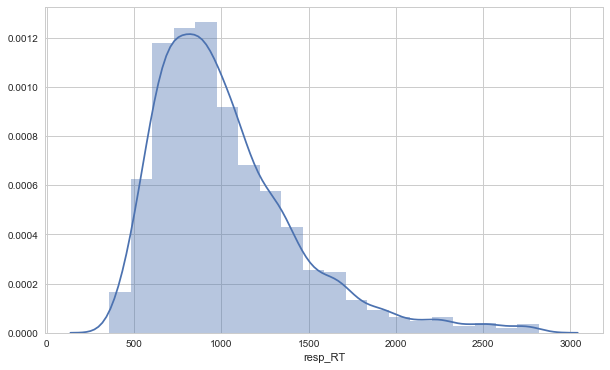

In [309]:
figsize(10,6)

p = sns.distplot(criticals_only['resp_RT'], bins=20)
fig = p.get_figure()
fig.savefig('descriptives/resp_RT_distribution.png')

### Log distribution of critical trial RTs

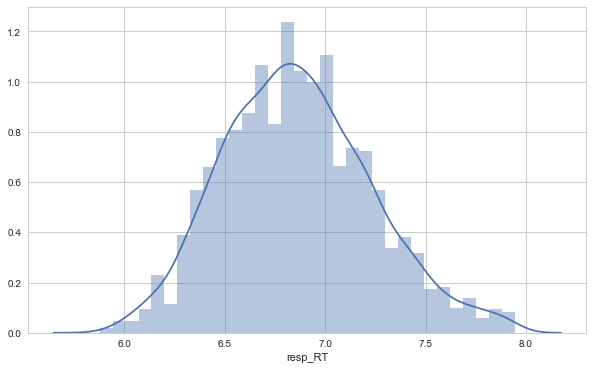

In [310]:
p = sns.distplot(np.log(criticals_only['resp_RT']))
fig = p.get_figure()
fig.savefig('descriptives/log_resp_RT.png')

### Define function to compute performance

In [311]:
def compute_performance(performance_subset, index_by, count_which):
    
    # Get individual items
    items = pd.unique(performance_subset[index_by])
    
    # Index the subset by `index_by`, including columsn block accuracy and critical reached
    performance = pd.DataFrame(
        columns=['block_acc', 'critical_reached'],
        index=pd.Index(items, name=index_by),
        dtype=np.float64
    )
    
    # Go through items to get averages
    for item in items:
        completed_sentences = performance_subset.loc[
            (performance_subset[index_by] == item) &
            (performance_subset['block_acc'] == 1)
        ][count_which]
        
        reached_criticals = performance_subset.loc[
            (performance_subset[index_by] == item) &
            (performance_subset['critical_reached'] == 1)
        ][count_which]
        
        performance.loc[item]['block_acc'] = (
            completed_sentences.count()
            / len(pd.unique(performance_subset[count_which])) * 100
        )
        
        performance.loc[item]['critical_reached'] = (
            reached_criticals.count()
            / len(pd.unique(performance_subset[count_which])) * 100
        )
    
    return performance

# Get the first word in each sentence to extract the sentence-level information
# filtered_performance = participants_flat.loc[
#     (participants_flat['sentence_index'] == 0),
#     ['participant', 'sentence_number', 'block_acc', 'critical_reached', 'sentence_index']
# ]

filtered_performance = participants_flat.loc[
    (participants_flat['participant'].isin(criticals_only['participant'])) &
    (participants_flat['sentence_number'].isin(criticals_only['sentence_number'])) &
    (participants_flat['sentence_index'] == 0)
][['participant', 'sentence_number', 'block_acc', 'critical_reached', 'sentence_index']]

# sorted(filtered_performance.groupby('participant').sum()['critical_reached'])

### Compute participant perfomance descriptives

,block_acc,critical_reached
count,50.000000,50.000000
mean,76.263736,80.065934
std,7.048648,6.295153
min,59.340659,62.637363
25%,71.428571,75.824176
50%,75.824176,80.219780
75%,81.318681,84.615385
max,90.109890,91.208791


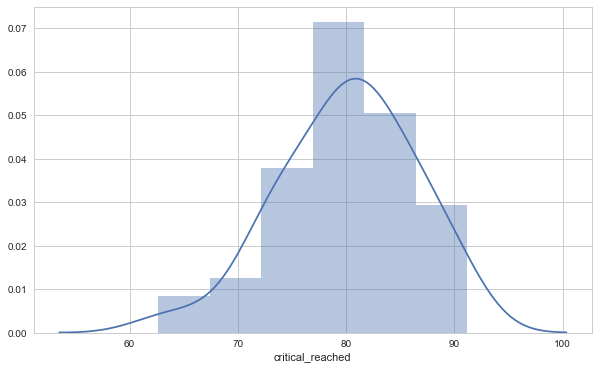

In [312]:
participant_performance = compute_performance(filtered_performance, 'participant', 'sentence_number')

display(participant_performance[['block_acc', 'critical_reached']].describe())

p = sns.distplot(participant_performance['critical_reached'])
fig = p.get_figure()
fig.savefig('descriptives/participant_performance.png')

### Compute sentence performance descriptives

,block_acc,critical_reached
count,91.000000,91.000000
mean,76.263736,80.065934
std,17.158629,16.084362
min,32.000000,36.000000
25%,68.000000,72.000000
50%,82.000000,84.000000
75%,88.000000,91.000000
max,100.000000,100.000000


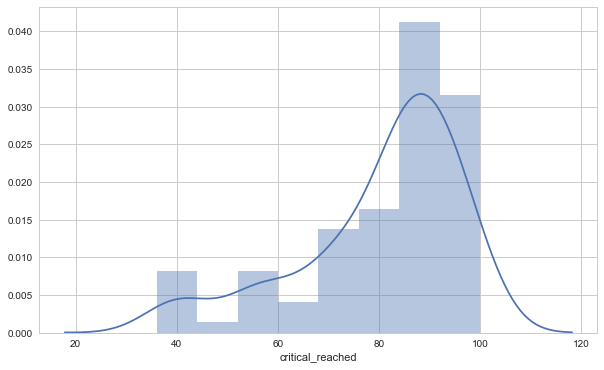

In [313]:
sentence_performance = compute_performance(filtered_performance, 'sentence_number', 'participant')

display(sentence_performance[['block_acc', 'critical_reached']].describe())

p = sns.distplot(sentence_performance['critical_reached'])
fig = p.get_figure()
fig.savefig('descriptives/sentence_performance.png')

### Compute performance, grouped by condition

resp_RT                                                          \
            count         mean         std    min    25%     50%      75%   
condition                                                                   
1           755.0  1103.866225  439.007401  400.0  800.5  1011.0  1326.50   
2           948.0  1087.112869  425.672288  380.0  779.0   991.5  1285.25   
3           927.0   970.663430  390.551893  357.0  695.0   885.0  1138.00   
4           937.0   955.875133  375.490623  379.0  695.0   884.0  1115.00   

                  resp_acc                                               
              max    count      mean       std  min  25%  50%  75%  max  
condition                                                                
1          2758.0    755.0  0.982781  0.130171  0.0  1.0  1.0  1.0  1.0  
2          2803.0    948.0  0.987342  0.111853  0.0  1.0  1.0  1.0  1.0  
3          2694.0    927.0  0.989213  0.103357  0.0  1.0  1.0  1.0  1.0  
4          2820.0    937.0  0.994664  0.072893  0.0  1.0  1.0  1.0  1.0

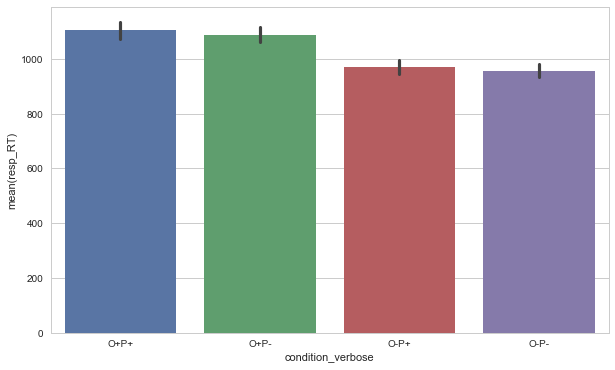

In [314]:
condition_groups = criticals_only[['condition', 'resp_RT', 'resp_acc']].groupby('condition').describe()
display(condition_groups)

p = sns.barplot(x='condition_verbose', y='resp_RT', order=['O+P+', 'O+P-', 'O-P+', 'O-P-'], data=criticals_only)
fig = p.get_figure()
fig.savefig('descriptives/resp_RT_by_condition.png')

---

# Data analysis

### Compute the inverse RT

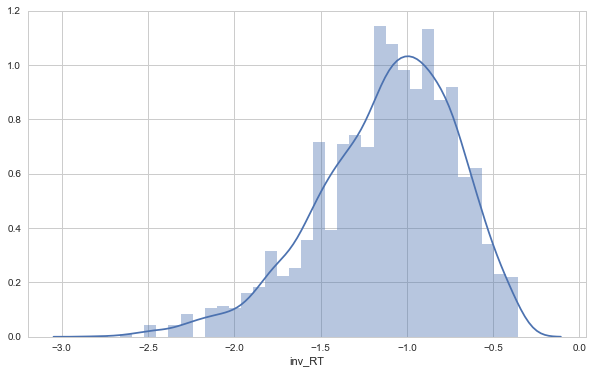

In [315]:
criticals_only['inv_RT'] = -1000/criticals_only['resp_RT']

p = sns.distplot(criticals_only['inv_RT'])
fig = p.get_figure()
fig.savefig('descriptives/inverse_resp_RT.png')

### Center the categories

In [316]:
criticals_only['ortho_center'] = criticals_only.apply(lambda row: (-1/2 if row['ortho_similarity'] == 0 else 1/2), axis=1)
criticals_only['phono_center'] = criticals_only.apply(lambda row: (-1/2 if row['phono_similarity'] == 0 else 1/2), axis=1)

display(criticals_only[:10][['inv_RT', 'condition', 'ortho_center', 'phono_center']])


,inv_RT,condition,ortho_center,phono_center
10,-1.531394,3,-0.5,0.5
21,-1.757469,4,-0.5,-0.5
26,-0.593824,2,0.5,-0.5
57,-1.356852,3,-0.5,0.5
64,-1.976285,4,-0.5,-0.5
73,-0.896057,2,0.5,-0.5
93,-0.650618,1,0.5,0.5
100,-1.828154,2,0.5,-0.5
107,-1.283697,4,-0.5,-0.5
125,-2.155172,3,-0.5,0.5


---
### Write filtered data to file

In [317]:
criticals_only.to_csv('output/criticals_only-filtered.csv', sep='\t')

---